In [61]:
#Options and todos:

#Options for preprocessing:
#Data is weighted to the amount of target_channels it ends up on the same day as (so more than one target_channel means more weight to interactions on that day)
#noduped overall so that channel by day normalizes outside of payment days so that more volume per day doesn't mean more weight, speaking more frequency of interactions and their commonality to the y-variable

#todos:
#**add in 5,15,30 payments from the first OR last contact 
#^^(maybe do different nn's for those to see which is most important, 
#^^first needs parameters like no longer than 5 days before the payment depending on the contact)
#^^last needs the same parameters

In [62]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from itertools import chain, combinations
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from imblearn.over_sampling import SMOTE

# Load the data
data = pd.read_csv(r"C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\DL\channel_engage\data\preprocessed_data.csv")
print(data.head())
#get unique target_channels
target_channels = data['target_channel'].unique()
print(target_channels)

   month  EMAIL  OUTBOUND  TEXT target_channel   dlq_30   dlq_60   dlq_90  \
0      1      1         1     1           PYMT  current  current  current   
1      2      1         1     1           PYMT  current  current  current   
2      2      1         1     1           PYMT  current  current  current   
3      2      1         1     1           PYMT  current  current  current   
4      2      1         1     1           PYMT  current  current  current   

  exclusion_type        roll_30        roll_60        roll_90 segment  bucket  \
0       elgiible   roll forward   roll forward   roll forward    cure       1   
1       elgiible  roll backward  roll backward  roll backward    cure       1   
2       elgiible  roll backward  roll backward  roll backward    cure       1   
3       elgiible  roll backward  roll backward  roll backward    cure       1   
4       elgiible   roll forward  roll backward  roll backward    cure       1   

  long_term_risk_score acct_balance_segments tot_d

In [63]:
# Define feature lists
numerical_features = [ 'year', 'month', 'day', 'EMAIL', 'TEXT', 'OUTBOUND']
categorical_features = [col for col in data.columns if col not in numerical_features + [ 'target_channel']] #'interaction_channel' is needed in here while target_channel is the y variable

# Define transformers
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Define X and y
X = data.drop(columns=['target_channel'])
print(X.head())
# Use LabelEncoder to encode target_channel
label_encoder = LabelEncoder()
y = data['target_channel']
y_encoded = label_encoder.fit_transform(y)
#print(y_encoded)

# Preprocess the data
X = preprocessor.fit_transform(X)
#print(X)

# If X is a sparse matrix, convert to a dense matrix
if hasattr(X, "todense"):
    X = X.todense()

X = np.asarray(X)

# Split the data
X_train, X_temp, y_train_encoded, y_temp_encoded = train_test_split(X, y_encoded, test_size=0.4, stratify=y_encoded) # can add stratify=y_encoded to make sure the split is even
X_val, X_test, y_val_encoded, y_test_encoded = train_test_split(X_temp, y_temp_encoded, test_size=0.5, stratify=y_temp_encoded) # can add stratify=y_encoded to make sure the split is even

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train_encoded)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val_encoded)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test_encoded)

# Convert to PyTorch datasets and create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




   month  EMAIL  OUTBOUND  TEXT   dlq_30   dlq_60   dlq_90 exclusion_type  \
0      1      1         1     1  current  current  current       elgiible   
1      2      1         1     1  current  current  current       elgiible   
2      2      1         1     1  current  current  current       elgiible   
3      2      1         1     1  current  current  current       elgiible   
4      2      1         1     1  current  current  current       elgiible   

         roll_30        roll_60        roll_90 segment  bucket  \
0   roll forward   roll forward   roll forward    cure       1   
1  roll backward  roll backward  roll backward    cure       1   
2  roll backward  roll backward  roll backward    cure       1   
3  roll backward  roll backward  roll backward    cure       1   
4   roll forward  roll backward  roll backward    cure       1   

  long_term_risk_score acct_balance_segments tot_delq_balance_segments  \
0              0.4-0.6               100-500                   100

In [64]:
print(X_train_tensor.shape, y_train_tensor.shape, X_val_tensor.shape, y_val_tensor.shape, X_test_tensor.shape, y_test_tensor.shape)
print(data['target_channel'].value_counts())


torch.Size([155, 30]) torch.Size([155]) torch.Size([52, 30]) torch.Size([52]) torch.Size([52, 30]) torch.Size([52])
NO_PYMT    176
PYMT        83
Name: target_channel, dtype: int64


In [65]:
# Assuming you have the number of unique classes in a variable num_classes
num_classes = len(y.unique())  # Number of unique classes in the target variable
print(num_classes, "unique target channels =", y.unique())

# Define the neural network for binary classification
class BinaryClassNet(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(64, 1)  # Only one output unit for binary classification
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

    def predict(self, x):
        # Switch model to evaluation mode
        self.eval()
        with torch.no_grad():
            outputs = self.forward(x)
            predicted = (torch.sigmoid(outputs) > 0.5).float()  # Convert probabilities to binary outputs
        return predicted.numpy()

BinaryClassNet = BinaryClassNet(X_train.shape[1])
model = BinaryClassNet

# Change the loss function for binary classification
loss_fn = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(BinaryClassNet.parameters(), lr=0.001, weight_decay=1e-5)



2 unique target channels = ['PYMT' 'NO_PYMT']


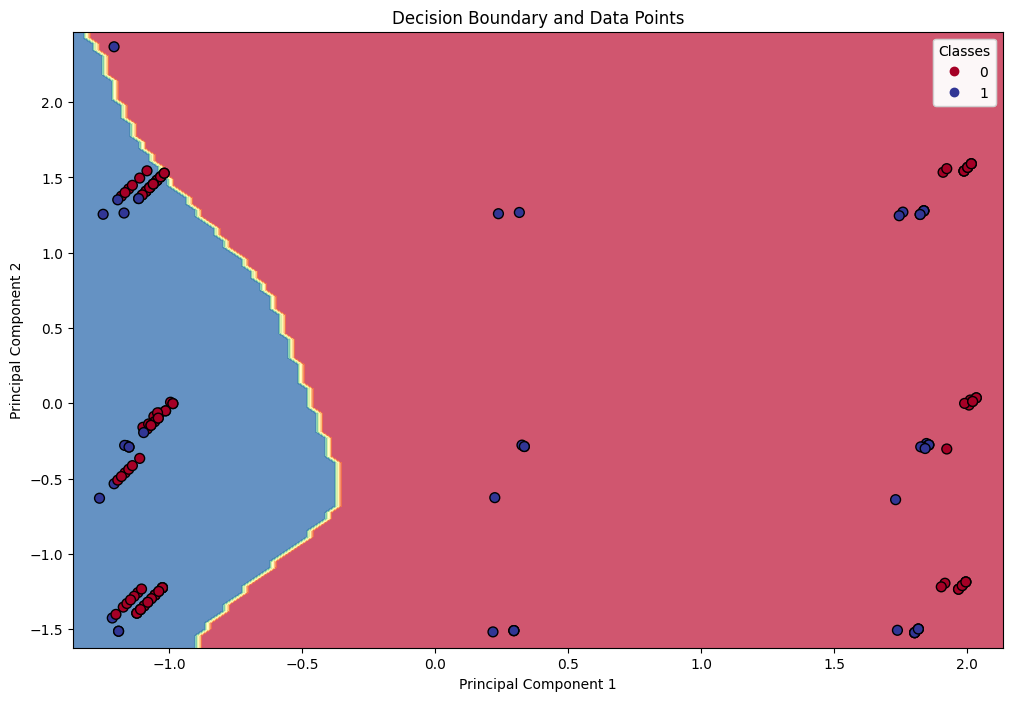

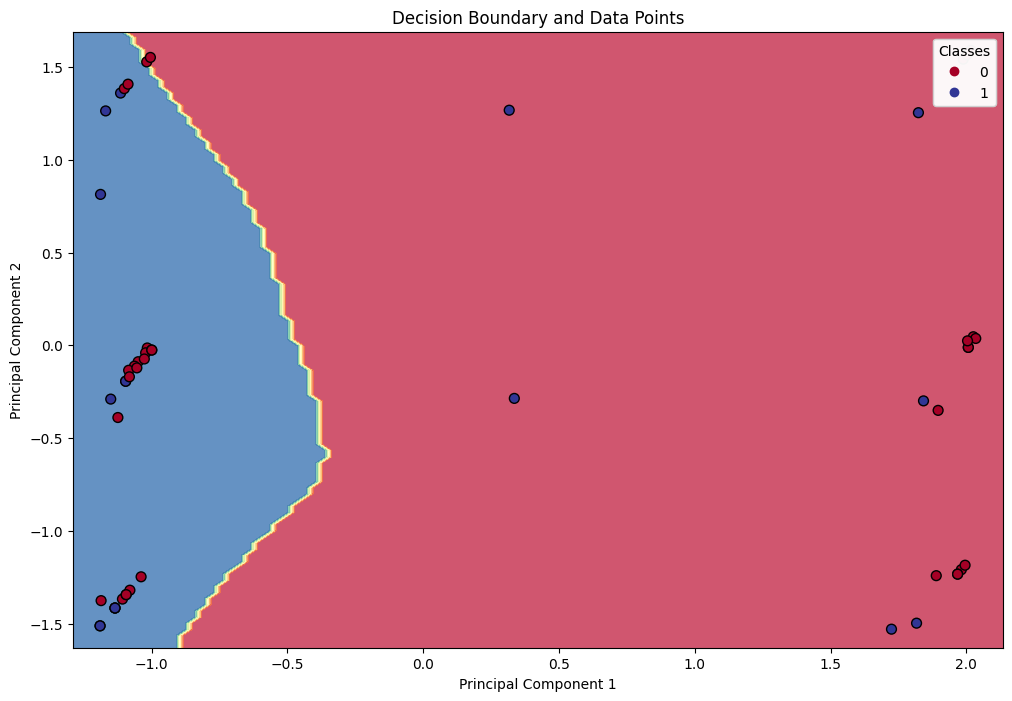

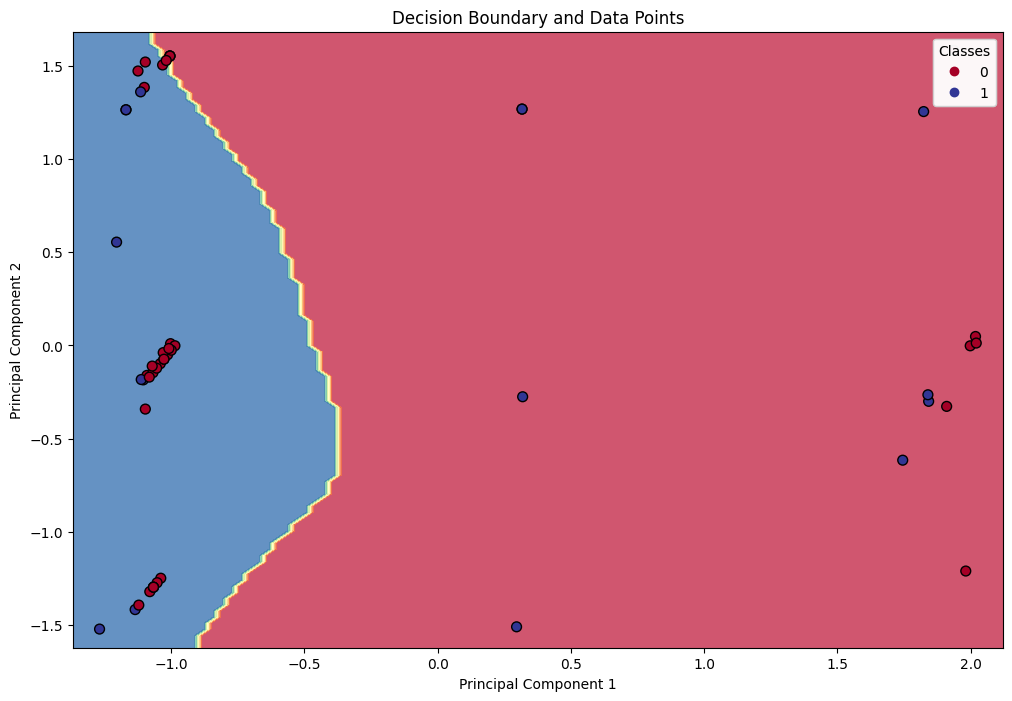

In [66]:
from sklearn.decomposition import PCA

# Reduce the dataset to 2D using PCA for visualization
pca = PCA(n_components=2)

X_train_2D = pca.fit_transform(X_train)
X_val_2D = pca.transform(X_val)
X_test_2D = pca.transform(X_test)

def plot_multiclass_decision_boundary_pytorch(model, pca, X, y, savefig_fp=None):
    """Plot the multiclass decision boundary for a model with high-dimensional inputs, using PCA for visualization."""
    # Axis boundaries
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Create predictions
    x_in = np.c_[xx.ravel(), yy.ravel()]
    # Inverse transform the 2D points back to the original space
    x_in_original_space = pca.inverse_transform(x_in)
    # Convert to tensor
    x_in_tensor = torch.FloatTensor(x_in_original_space)
    # Get predictions from model
    y_pred = model.predict(x_in_tensor)
    y_pred = y_pred.reshape(xx.shape)

    # Plot decision boundary
    plt.figure(figsize=(12, 8))  # You can adjust the size as needed
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='k', cmap=plt.cm.RdYlBu)  # s controls the size of the dots, edgecolor provides a border to the dots
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title('Decision Boundary and Data Points')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    # Legend
    legend1 = plt.legend(*scatter.legend_elements(),
                         loc="upper right", title="Classes")
    plt.gca().add_artist(legend1)

    # Save plot
    if savefig_fp:
        plt.savefig(savefig_fp, format="png")

    plt.show()


# Then use the adjusted plotting function with your data:
plot_multiclass_decision_boundary_pytorch(model, pca, X_train_2D, y_train_encoded)
plot_multiclass_decision_boundary_pytorch(model, pca, X_val_2D, y_val_encoded)
plot_multiclass_decision_boundary_pytorch(model, pca, X_test_2D, y_test_encoded)


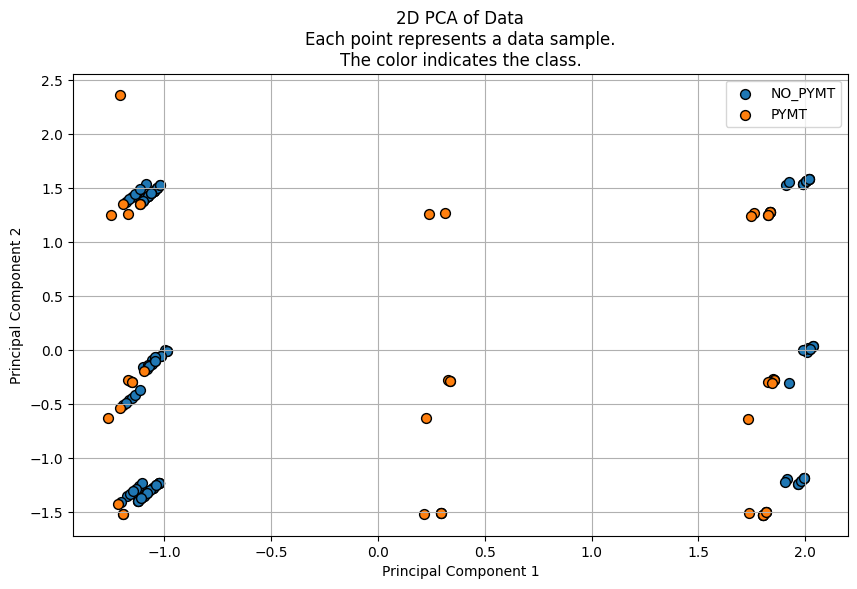

In [67]:
#when you reduce the data's dimensionality using PCA down to two dimensions, the output consists of two principal components (PC1 and PC2). 
# These components capture the maximum variance in the data. When visualized, PC1 is typically plotted on the x-axis and PC2 on the y-axis.
from sklearn.decomposition import PCA

def visualize_pca_2d(X, y_encoded):
    y_original = label_encoder.inverse_transform(y_encoded)
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X)
    plt.figure(figsize=(10, 6))
    for label in np.unique(y_original):
        mask = y_original == label
        plt.scatter(principalComponents[mask, 0], principalComponents[mask, 1], edgecolor='k', s=50, label=label)
    plt.legend()
    plt.title('2D PCA of Data\nEach point represents a data sample.\nThe color indicates the class.')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()

visualize_pca_2d(X_train, y_train_encoded)


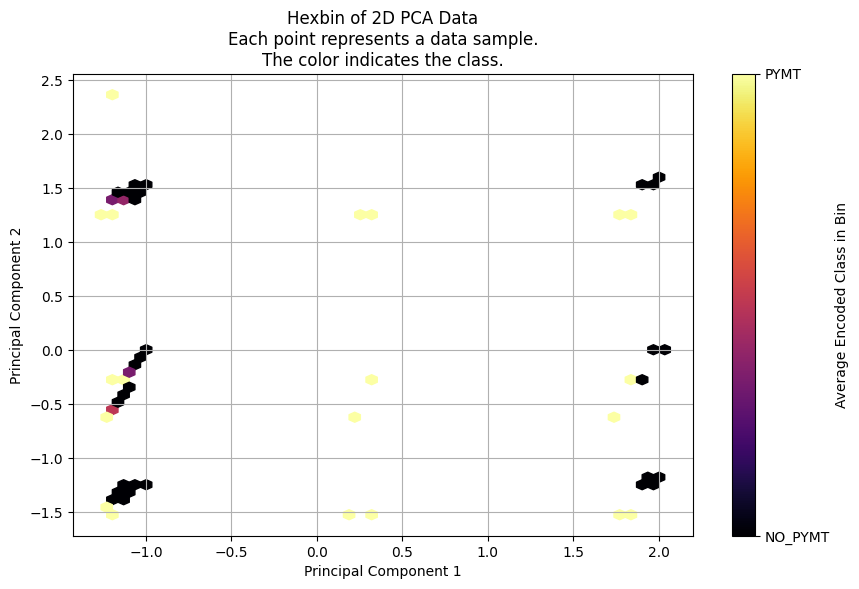

In [68]:
def hexbin_plot(X, y_encoded):
    y_original = label_encoder.inverse_transform(y_encoded)
    unique_labels = np.unique(y_original)
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    y_mapped = np.array([label_map[label] for label in y_original])
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X)
    plt.figure(figsize=(10, 6))
    hb = plt.hexbin(principalComponents[:, 0], principalComponents[:, 1], C=y_mapped, gridsize=50, cmap='inferno')
    cbar = plt.colorbar(hb, label='Average Encoded Class in Bin')
    cbar.set_ticks(list(label_map.values()))
    cbar.set_ticklabels(list(label_map.keys()))
    plt.title('Hexbin of 2D PCA Data\nEach point represents a data sample.\nThe color indicates the class.')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()

hexbin_plot(X_train, y_train_encoded)


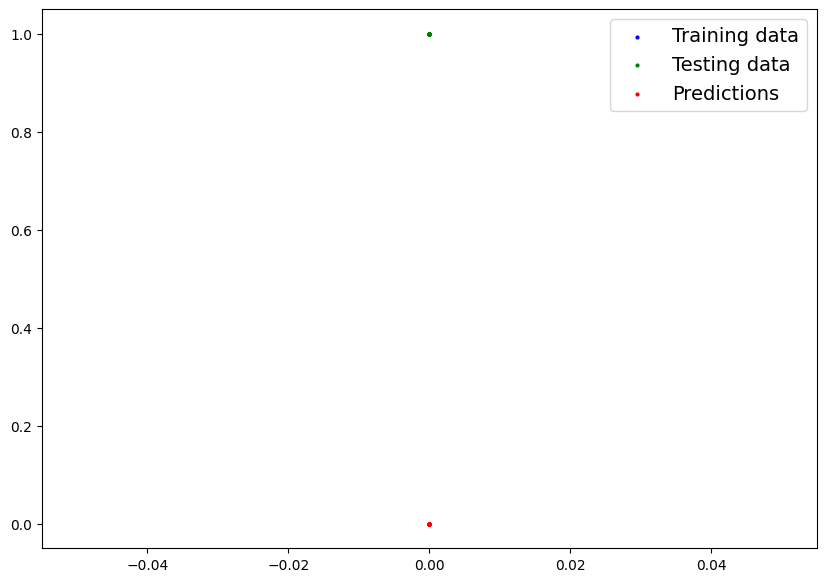

In [69]:
# Predictions in inference mode
with torch.no_grad():  # We use torch.no_grad() instead of torch.inference_mode() (which might not be available in all versions)
    logits = model(X_test_tensor)
    y_preds = torch.argmax(logits, dim=1).numpy()

# Visualizing the predictions vs actual
def plot_predictions(train_data, train_labels,
                     test_data, test_labels,
                     predictions=None):
    """
    Plots training data, test data, and compares predictions.
    """
    plt.figure(figsize=(10, 7))
    
    # Assuming data might still be in tensor form, convert to numpy
    if isinstance(train_data, torch.Tensor):
        train_data = train_data.numpy()
        train_labels = train_labels.numpy()
    if isinstance(test_data, torch.Tensor):
        test_data = test_data.numpy()
        test_labels = test_labels.numpy()

    # Plot training data in blue
    # Using just the first dimension of data for simplicity
    plt.scatter(train_data[:, 0], train_labels, c="b", s=4, label="Training data")
    
    # Plot test data in green
    plt.scatter(test_data[:, 0], test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data[:, 0], predictions, c="r", s=4, label="Predictions")
    
    # Show the legend
    plt.legend(prop={"size": 14})
    plt.show()

# Call the plotting function
plot_predictions(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, predictions=y_preds)


    Forward pass: Compute the model's predictions based on the input data.
    Compute loss: Use a loss function to measure how well the model's predictions match the desired outputs.
    Zero gradients: Clear out the gradients accumulated from the last iteration.
    Backward pass: Compute the gradients of the loss with respect to the model's parameters.
    Optimizer step: Update the model's parameters based on the computed gradients.

The reason for this order is mainly intuitive:

    First, you want to see what your model predicts (forward pass).
    Then, you want to know how wrong or right it is (compute loss).
    Before updating your model, you'll clear any old gradients (zero gradients).
    You then find out how your loss changes as you tweak each parameter (backward pass).
    Finally, you make a step to adjust your model's parameters in the direction that reduces the loss (optimizer step).
    

Epoch 10/100 - Training Loss: 0.6136, Validation Loss: 0.6027, Validation Accuracy: 67.31%
Epoch 20/100 - Training Loss: 0.5496, Validation Loss: 0.5443, Validation Accuracy: 67.31%
Epoch 30/100 - Training Loss: 0.4529, Validation Loss: 0.4601, Validation Accuracy: 80.77%
Epoch 40/100 - Training Loss: 0.3140, Validation Loss: 0.3633, Validation Accuracy: 80.77%
Epoch 50/100 - Training Loss: 0.1974, Validation Loss: 0.2739, Validation Accuracy: 88.46%
Epoch 60/100 - Training Loss: 0.1356, Validation Loss: 0.2165, Validation Accuracy: 88.46%
Epoch 70/100 - Training Loss: 0.1022, Validation Loss: 0.1780, Validation Accuracy: 88.46%
Epoch 80/100 - Training Loss: 0.1041, Validation Loss: 0.1884, Validation Accuracy: 88.46%
Epoch 90/100 - Training Loss: 0.0908, Validation Loss: 0.1484, Validation Accuracy: 92.31%
Epoch 100/100 - Training Loss: 0.0989, Validation Loss: 0.1649, Validation Accuracy: 88.46%


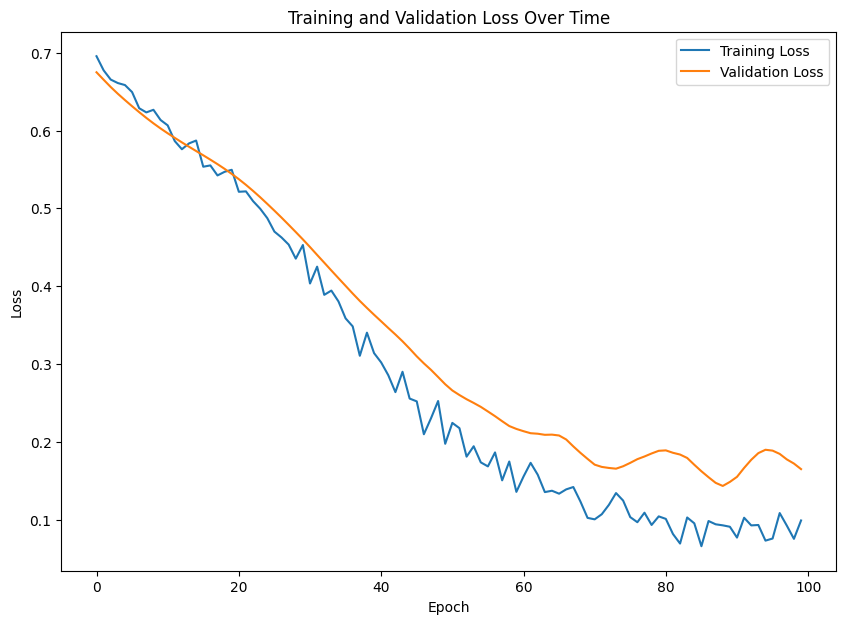

Test Accuracy: 92.31%


In [70]:
import torch
from matplotlib import pyplot as plt

# Update the prediction function for binary classification
def predict(model, data):
    """Get model predictions."""
    outputs = model(data)
    predicted = (torch.sigmoid(outputs) > 0.5).long()
    return predicted.squeeze()

epochs = 100

def train_model(model, loss_fn, optimizer, train_loader, val_loader, epochs):
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        # Set model to training mode
        model.train()

        # Training loop
        total_loss = 0
        for batch in train_loader:
            # Split batch into data and target
            data, target = batch

            # Forward pass
            outputs = model(data)

            # Calculate loss
            loss = loss_fn(outputs, target.unsqueeze(1).float())

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Backward pass
            loss.backward()

            # Optimization step
            optimizer.step()

            # Accumulate loss for the epoch
            total_loss += loss.item()

        average_train_loss = total_loss / len(train_loader)
        train_loss_history.append(average_train_loss)

        # Validation loop
        model.eval()  # Set model to evaluation mode
        total_val_loss = 0
        correct = 0
        with torch.inference_mode():
            for batch in val_loader:
                data, target = batch
                outputs = model(data)

                # Calculate loss
                loss = loss_fn(outputs, target.unsqueeze(1).float())

                # Accumulate loss for the epoch
                total_val_loss += loss.item()

                # Count correct predictions
                pred = predict(model, data)
                correct += (pred == target).sum().item()

        average_val_loss = total_val_loss / len(val_loader)
        val_loss_history.append(average_val_loss)

        # Print loss and accuracy for the epoch every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Training Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {100 * correct/len(val_loader.dataset):.2f}%")

    return train_loss_history, val_loss_history

# Train the model
# NOTE: MultiClassNet, loss_fn, optimizer, train_loader, and val_loader should be defined elsewhere in your code.
train_loss, val_loss = train_model(BinaryClassNet, loss_fn, optimizer, train_loader, val_loader, epochs)


# Plot the training and validation loss
plt.figure(figsize=(10,7))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

# Evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.inference_mode():
        for data, target in test_loader:
            # Get predictions using the predict function
            predicted = predict(model, data).squeeze()
            total += target.size(0)
            correct += (predicted == target).sum().item()

    print(f'Test Accuracy: {100 * correct/total:.2f}%')

# NOTE: BinaryClassNet and test_loader should be defined elsewhere in your code.
evaluate_model(BinaryClassNet, test_loader)


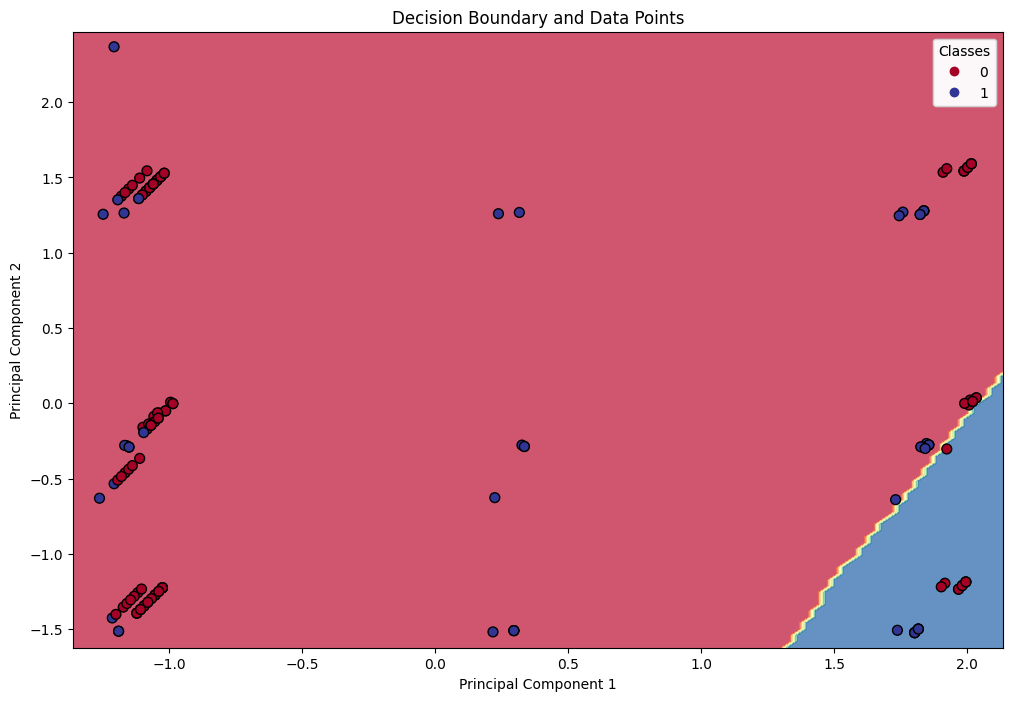

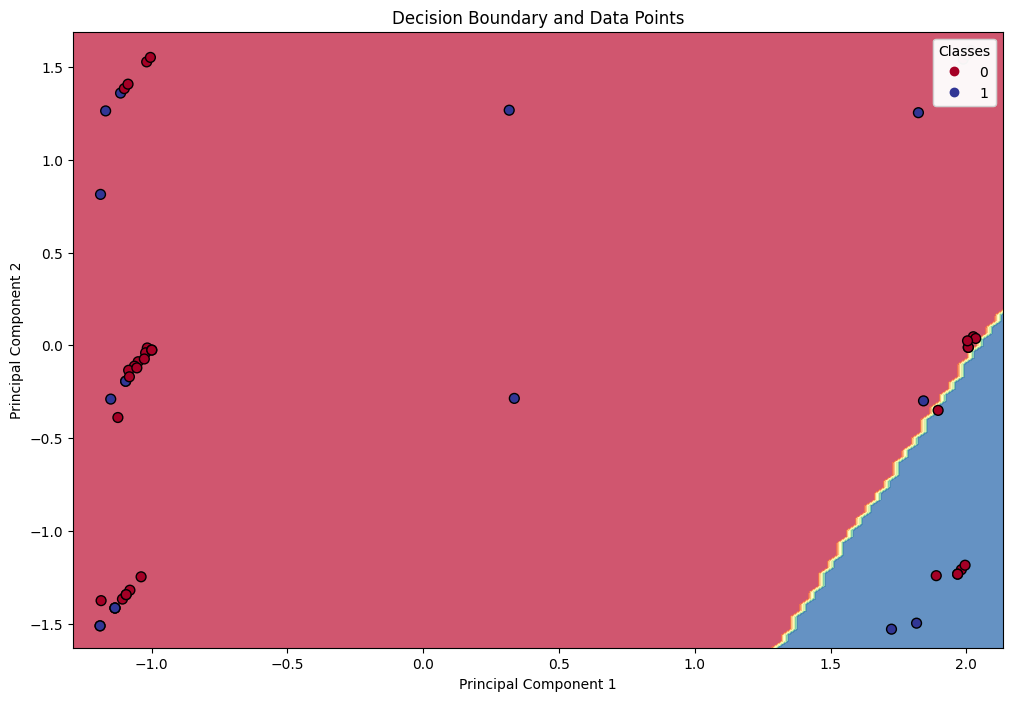

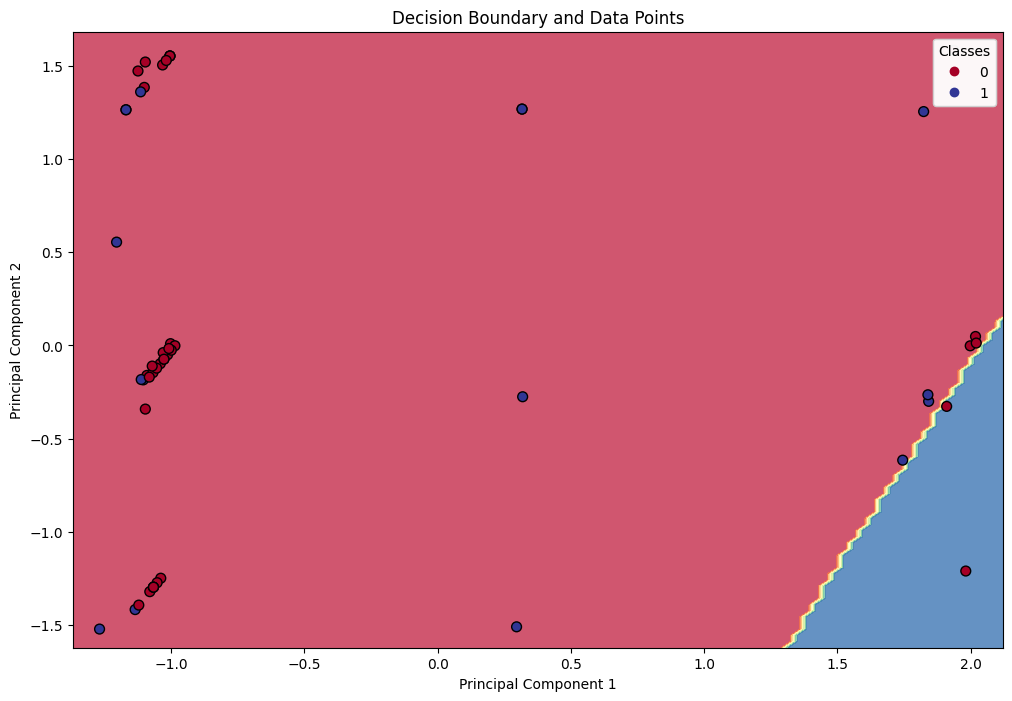

In [71]:
# Then use the adjusted plotting function with your data:
plot_multiclass_decision_boundary_pytorch(model, pca, X_train_2D, y_train_encoded)
plot_multiclass_decision_boundary_pytorch(model, pca, X_val_2D, y_val_encoded)
plot_multiclass_decision_boundary_pytorch(model, pca, X_test_2D, y_test_encoded)

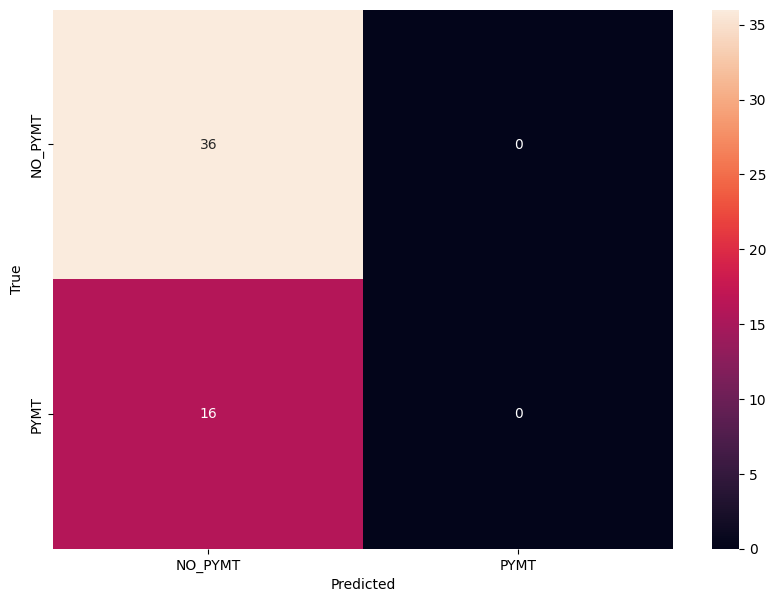

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(true, preds, classes):
    matrix = confusion_matrix(true, preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix, annot=True, fmt="d",
                xticklabels=classes,
                yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Get model predictions
with torch.no_grad():
    logits = model(X_test_tensor)
    y_preds = torch.argmax(logits, dim=1).numpy()

plot_confusion_matrix(y_test_encoded, y_preds, classes=label_encoder.classes_)


Metric name/Evaluation method 	Defintion 	Code

Accuracy 	Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. 	torchmetrics.Accuracy() or sklearn.metrics.accuracy_score()

Precision 	Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). 	torchmetrics.Precision() or sklearn.metrics.precision_score()

Recall 	Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. 	torchmetrics.Recall() or sklearn.metrics.recall_score()

F1-score 	Combines precision and recall into one metric. 1 is best, 0 is worst. 	torchmetrics.F1Score() or sklearn.metrics.f1_score()

Confusion matrix 	Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). 	torchmetrics.ConfusionMatrix or sklearn.metrics.plot_confusion_matrix()

Classification report 	Collection of some of the main classification metrics such as precision, recall and f1-score. 	sklearn.metrics.classification_report()


In [73]:
#metrics to consider: 
#changes or additions: see by each class of ltr, channels, segment, roll rate, etc

#    Classification Report: This provides a breakdown of precision, recall, and f1-score for each class.
#    Macro and Micro Averaging: Especially useful if there's a class imbalance.
#    ROC Curve for Multi-class: Compute the ROC curve for each class against the rest, then visualize all the ROC curves together.
#    Area Under Curve (AUC) for Multi-class: Like the ROC, but provides a single score for each class's performance.
#    Log-Loss: Gives a measure of model's performance; smaller values are better.

from sklearn.metrics import classification_report, roc_curve, auc, log_loss
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Predictions: could also use y_pred = MultiClassNet(X_test_tensor).argmax(dim=1).numpy()
y_pred_test_probs = model(X_test_tensor)
y_pred_test = torch.argmax(y_pred_test_probs, dim=1).numpy()

# Classification Report: This provides a breakdown of precision, recall, and f1-score for each class.
unique_labels = np.unique(np.concatenate((y_test_encoded, y_pred_test), axis=0))
print(classification_report(y_test_encoded, y_pred_test, labels=unique_labels, target_names=label_encoder.classes_[unique_labels]))


# ROC and AUC for multi-class
#An AUC of 1.0 means the model has perfect discrimination, while an AUC of 0.5 means the model is no better than random guessing. Under 0.5 means the class labels might be inverted, or the classifier is consistently wrong. This is usually an anomaly.
#ROC curve by class, the closer to the top-left corner, the better the model is at predicting that class.
y_test_bin = label_binarize(y_test_encoded, classes=range(num_classes))
y_pred_bin = y_pred_test_probs.detach().numpy()

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves: ROC Curve for Multi-class: Compute the ROC curve for each class against the rest, then visualize all the ROC curves together.
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red']
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} ({1}) (area = {2:0.2f})'
             ''.format(i, label_encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multi-class data')
plt.legend(loc="lower right")
plt.show()

# Log-Loss: Gives a measure of model's performance; smaller values are better.
all_classes = np.arange(num_classes)  # Assuming num_classes is the total number of classes
loss = log_loss(y_test_encoded, y_pred_bin, labels=all_classes)
print(f"Log Loss: {loss:.4f}")



              precision    recall  f1-score   support

     NO_PYMT       0.69      1.00      0.82        36
        PYMT       0.00      0.00      0.00        16

    accuracy                           0.69        52
   macro avg       0.35      0.50      0.41        52
weighted avg       0.48      0.69      0.57        52



c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

IndexError: index 1 is out of bounds for axis 1 with size 1

Number of samples for interaction channel EMAIL: 2


c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1029: Undefine

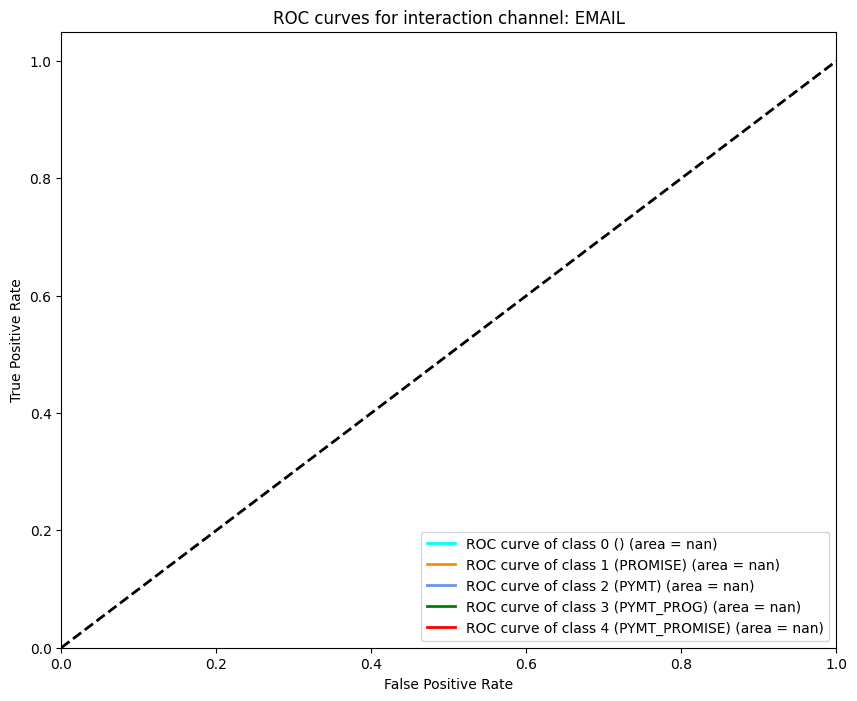

c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1029: Undefine

Number of samples for interaction channel TEXT: 4


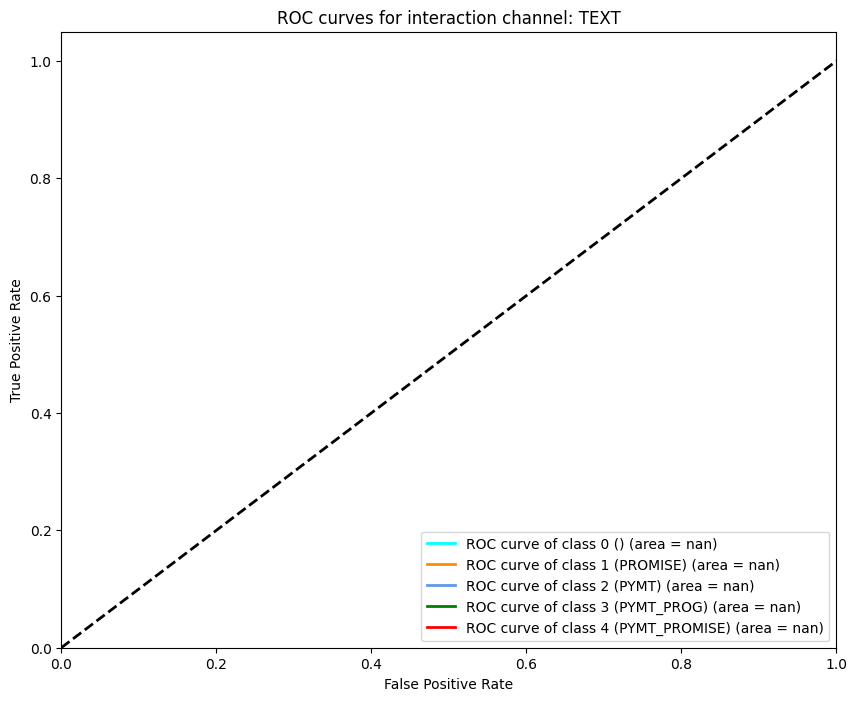

Number of samples for interaction channel OUTBOUND: 1


c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1029: Undefined

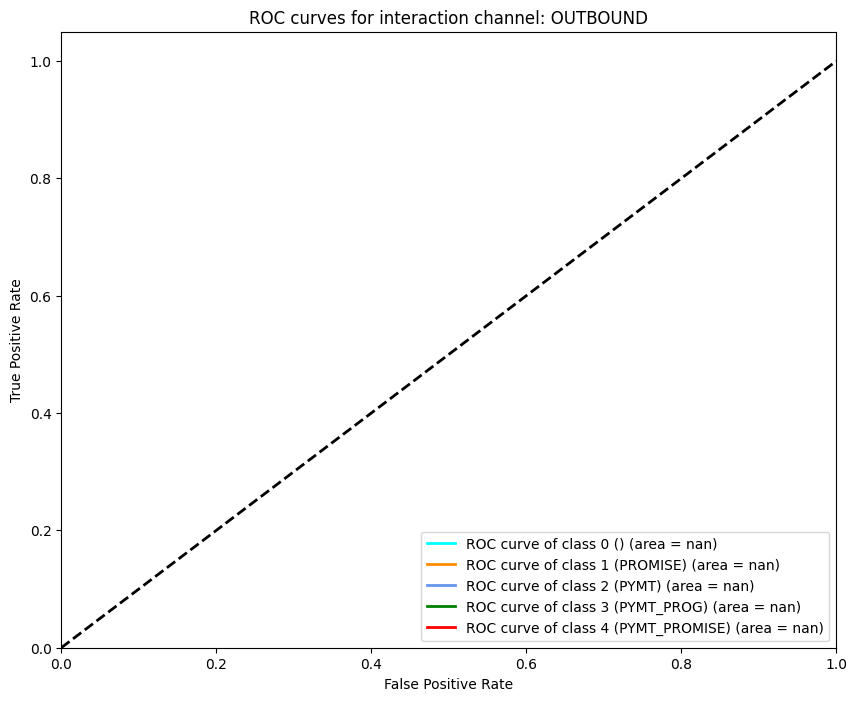

In [ ]:
def plot_roc_by_segment(X_data, y_true_encoded, y_pred, y_pred_probs, interaction_channels, label_encoder, num_classes):
    
    # Assuming interaction_channels are one-hot encoded consecutively in X_data
    interaction_start_idx = X_data.shape[1] - len(interaction_channels)
    
    for idx, channel in enumerate(interaction_channels):
        mask = X_data[:, interaction_start_idx + idx] == 1  # 1 indicates presence of that interaction channel
        
        y_true_segment = y_true_encoded[mask]
        y_pred_segment = y_pred[mask]
        y_pred_bin_segment = y_pred_probs[mask]

        # Print the number of samples for the current interaction channel
        print(f"Number of samples for interaction channel {channel}: {len(y_true_segment)}")
        
        # Check if y_true_segment is non-empty before proceeding
        if y_true_segment.size == 0:
            print(f"No samples for interaction channel: {channel} in the test set.")
            continue
        
        y_true_bin_segment = label_binarize(y_true_segment, classes=range(num_classes))
        
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin_segment[:, i], y_pred_bin_segment[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(10, 8))
        colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red']
        for i, color in zip(range(num_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label='ROC curve of class {0} ({1}) (area = {2:0.2f})'
                     ''.format(i, label_encoder.classes_[i], roc_auc[i]))
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC curves for interaction channel: {channel}')
        plt.legend(loc="lower right")
        plt.show()

# Assuming interaction_channels are the original column names for interaction channels before one-hot encoding
interaction_channels = ['EMAIL', 'TEXT', 'OUTBOUND']

plot_roc_by_segment(X_test, y_test_encoded, y_pred_test, y_pred_test_probs.detach().numpy(), interaction_channels, label_encoder, num_classes)